# AutoGluon para classificação de texto multilabel

José Augusto de Almeida Neto

## Instalar AutoGluon e Importar bibliotecas

In [ ]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2

In [ ]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

## Classe MultilabelPredictor e definição de parâmetros

In [201]:
# Definir a classe MultilabelPredictor personalizada para gerenciar uma coleção de objetos TabularPredictor, um para cada rótulo. 
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

## Carregar datasets

In [377]:
# Labels: quais colunas prever com base nas outras
labels = ['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']

# Problem type: tipo de problema da label
problem_types = ['binary'] * len(labels)

# Metrics: métricas que serão utilizadas para cada label
eval_metrics = ['f1'] * len(labels) 

In [378]:
# Carregar dataset
df_fold1 = pd.read_csv('../../datasets/dataset-fold_1-multilabel.csv', encoding='utf-8')
df_fold2 = pd.read_csv('../../datasets/dataset-fold_2-multilabel.csv', encoding='utf-8')
df_fold3 = pd.read_csv('../../datasets/dataset-fold_3-multilabel.csv', encoding='utf-8')
df_fold4 = pd.read_csv('../../datasets/dataset-fold_4-multilabel.csv', encoding='utf-8')
df_fold5 = pd.read_csv('../../datasets/dataset-fold_5-multilabel.csv', encoding='utf-8')

In [379]:
# Gerar listas de métricas
accuracies = []
f1_score_list_macro = []
precision_list_macro = []
recall_list_macro = []
f1_score_list_micro = []
precision_list_micro = []
recall_list_micro = []

## 1° Fold

In [380]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold2, df_fold3, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold1)

In [381]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=1000)

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_014118/"
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20230428_014118/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11374.16 MB
	Train Data (Original)  Memory Usage: 0.45 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerato

Fitting TabularPredictor for label: ambiente ...


	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['text_ngram'])             : 164 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp_

Fitting TabularPredictor for label: bebida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   1 | ['ambiente']
		('int', ['text_ngram'])             : 164 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.0s = Fit runtime
	2 features in or

Fitting TabularPredictor for label: comida ...


	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'be

Fitting TabularPredictor for label: geral ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])             : 164 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ..

Fitting TabularPredictor for label: localização ...


			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 's

Fitting TabularPredictor for label: outros ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('int', ['text_ngram

Fitting TabularPredictor for label: preço ...


			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sent

Fitting TabularPredictor for label: serviço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 7 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 163
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_014118/')


In [382]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [383]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 1° Fold:", accuracy)
print("F1 Score Macro do 1° Fold:", f1_score_macro)
print("Precisão Macro do 1° Fold:", precision_macro)
print("Revocação Macro do 1° Fold:", recall_macro)
print("F1 Score Micro do 1° Fold:", f1_score_micro)
print("Precisão Micro do 1° Fold:", precision_micro)
print("Revocação Micro do 1° Fold:", recall_micro)

Acurácia do 1° Fold: 0.62125
F1 Score Macro do 1° Fold: 0.7879237640580652
Precisão Macro do 1° Fold: 0.8006504367197402
Revocação Macro do 1° Fold: 0.7821770204667502
F1 Score Micro do 1° Fold: 0.8468531468531468
Precisão Micro do 1° Fold: 0.8681003584229391
Revocação Micro do 1° Fold: 0.8266211604095564


In [384]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9125
F1-Score: 0.8566
Precisão: 0.9543
Revocação: 0.7770
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9650
F1-Score: 0.8250
Precisão: 0.8462
Revocação: 0.8049
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8712
F1-Score: 0.8736
Precisão: 0.8967
Revocação: 0.8517
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8575
F1-Score: 0.7260
Precisão: 0.7190
Revocação: 0.7330
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9900
F1-Score: 0.8667
Precisão: 0.8667
Revocação: 0.8667
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9513
F1-Score: 0.3158
Precisão: 0.2571
Revocação: 0.4091
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9800
F1-Score: 0.9497
Precisão: 0.9618
Revocação: 0.9379
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

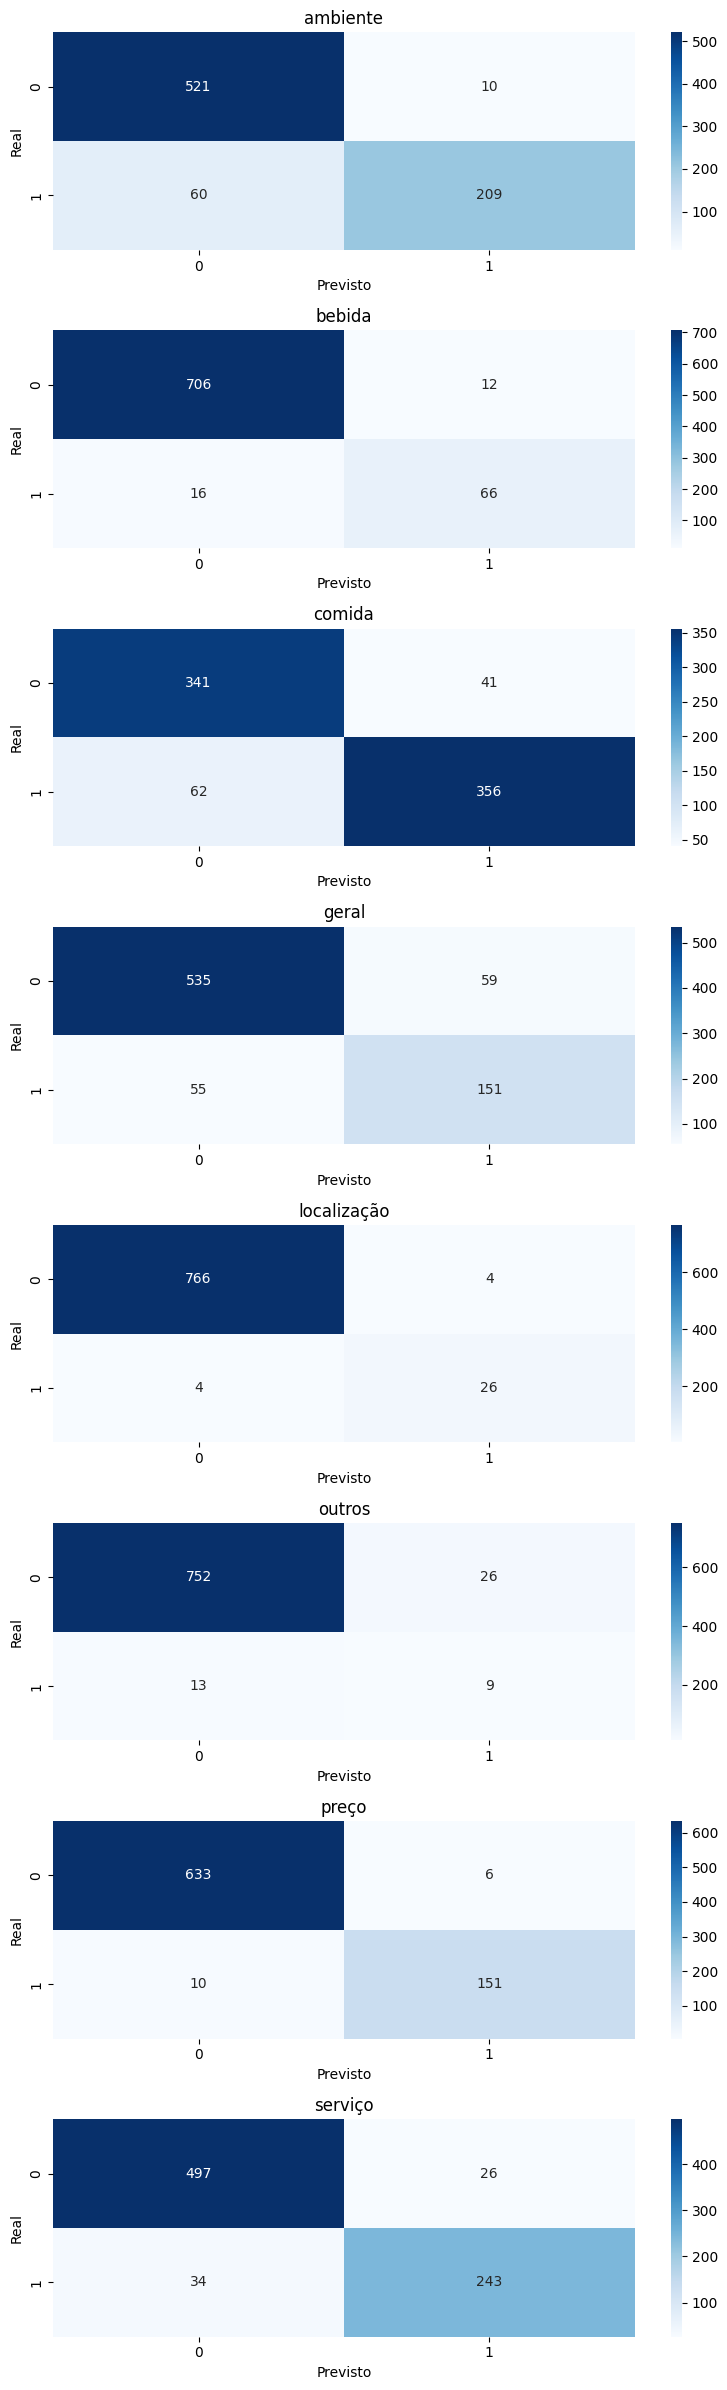

In [385]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 2° Fold

In [386]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold3, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold2)

In [387]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=1000)

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_014731/"
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20230428_014731/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11380.01 MB
	Train Data (Original)  Memory Usage: 0.45 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerato

Fitting TabularPredictor for label: ambiente ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	1.1s = Fit runtime
	1 features in original data used to generate 179 features in processed data.
	Train Data (Processed) Memory Usage: 1.09 MB (0.0% of 

Fitting TabularPredictor for label: bebida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   1 | ['ambiente']
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	1.1s = Fit runtime
	2 features in original data use

Fitting TabularPredictor for label: comida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	1.5s = Fit runtime
	3 features 

Fitting TabularPredictor for label: geral ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	1.0s = Fit 

Fitting TabularPredictor for label: localização ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   4 | ['ambiente', 'bebida', 'comida', 'geral']
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço',

Fitting TabularPredictor for label: outros ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__n

Fitting TabularPredictor for label: preço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

Fitting TabularPredictor for label: serviço ...


		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 161
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['text_ngram'])             : 162 | ['__nlp__.acessível

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_014731/')


In [388]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [389]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 2° Fold:", accuracy)
print("F1 Score Macro do 2° Fold:", f1_score_macro)
print("Precisão Macro do 2° Fold:", precision_macro)
print("Revocação Macro do 2° Fold:", recall_macro)
print("F1 Score Micro do 2° Fold:", f1_score_micro)
print("Precisão Micro do 2° Fold:", precision_micro)
print("Revocação Micro do 2° Fold:", recall_micro)

Acurácia do 2° Fold: 0.64375
F1 Score Macro do 2° Fold: 0.785753266089765
Precisão Macro do 2° Fold: 0.8127375566044479
Revocação Macro do 2° Fold: 0.7646787607113658
F1 Score Micro do 2° Fold: 0.8503207412687099
Precisão Micro do 2° Fold: 0.8772058823529412
Revocação Micro do 2° Fold: 0.8250345781466113


In [390]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9375
F1-Score: 0.8913
Precisão: 0.9361
Revocação: 0.8506
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9563
F1-Score: 0.7287
Precisão: 0.8246
Revocação: 0.6528
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8962
F1-Score: 0.8959
Precisão: 0.9015
Revocação: 0.8903
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8475
F1-Score: 0.7252
Precisão: 0.8010
Revocação: 0.6626
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9888
F1-Score: 0.8615
Precisão: 0.8750
Revocação: 0.8485
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9575
F1-Score: 0.3704
Precisão: 0.3333
Revocação: 0.4167
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9750
F1-Score: 0.9333
Precisão: 0.9459
Revocação: 0.9211
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

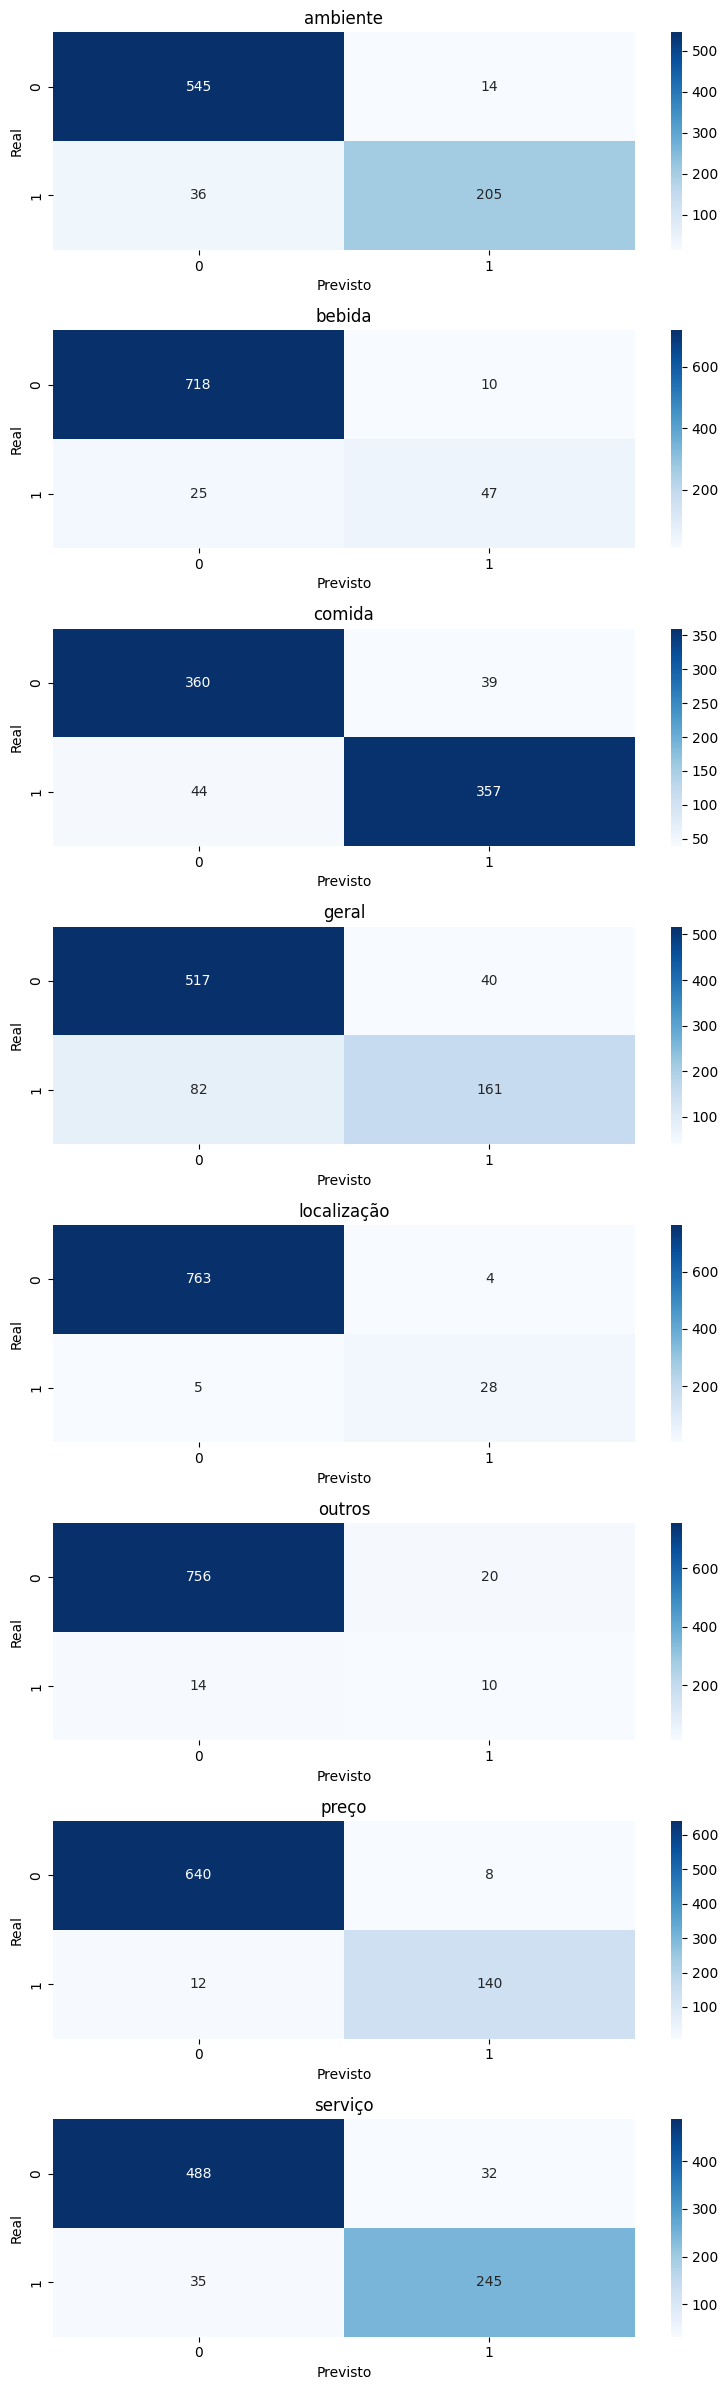

In [391]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 3° Fold

In [392]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold3)

In [393]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=1000)

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_015319/"
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20230428_015319/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11380.93 MB
	Train Data (Original)  Memory Usage: 0.64 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerato

Fitting TabularPredictor for label: ambiente ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['text_ngram'])             : 163 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.5s = Fit runtime
	1 features in original data used to generate 180 features in processed data.
	Train Data (Processed) Memory Usage: 1.

Fitting TabularPredictor for label: bebida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   1 | ['ambiente']
		('int', ['text_ngram'])             : 163 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.1s = Fit runtime
	2 features in or

Fitting TabularPredictor for label: comida ...


			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count'

Fitting TabularPredictor for label: geral ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])             : 163 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ..

Fitting TabularPredictor for label: localização ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   4 | ['ambiente', 'bebida', 'comida', 'geral']
		('int', ['text_ngram'])             : 163 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '

Fitting TabularPredictor for label: outros ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']


Fitting TabularPredictor for label: preço ...


			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sent

Fitting TabularPredictor for label: serviço ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 162
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['text_ngram'])             : 163 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradá

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_015319/')


In [394]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [395]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 3° Fold:", accuracy)
print("F1 Score Macro do 3° Fold:", f1_score_macro)
print("Precisão Macro do 3° Fold:", precision_macro)
print("Revocação Macro do 3° Fold:", recall_macro)
print("F1 Score Micro do 3° Fold:", f1_score_micro)
print("Precisão Micro do 3° Fold:", precision_micro)
print("Revocação Micro do 3° Fold:", recall_micro)

Acurácia do 3° Fold: 0.63375
F1 Score Macro do 3° Fold: 0.7892318351174097
Precisão Macro do 3° Fold: 0.8305664403679949
Revocação Macro do 3° Fold: 0.7548804068691116
F1 Score Micro do 3° Fold: 0.8535162950257289
Precisão Micro do 3° Fold: 0.8847795163584637
Revocação Micro do 3° Fold: 0.8243870112657389


In [396]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9213
F1-Score: 0.8578
Precisão: 0.9596
Revocação: 0.7755
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9587
F1-Score: 0.7815
Precisão: 0.8676
Revocação: 0.7108
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8938
F1-Score: 0.8972
Precisão: 0.9206
Revocação: 0.8750
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8438
F1-Score: 0.7444
Precisão: 0.7745
Revocação: 0.7165
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9875
F1-Score: 0.8913
Precisão: 0.9318
Revocação: 0.8542
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9637
F1-Score: 0.3256
Precisão: 0.3684
Revocação: 0.2917
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9675
F1-Score: 0.9161
Precisão: 0.9530
Revocação: 0.8820
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

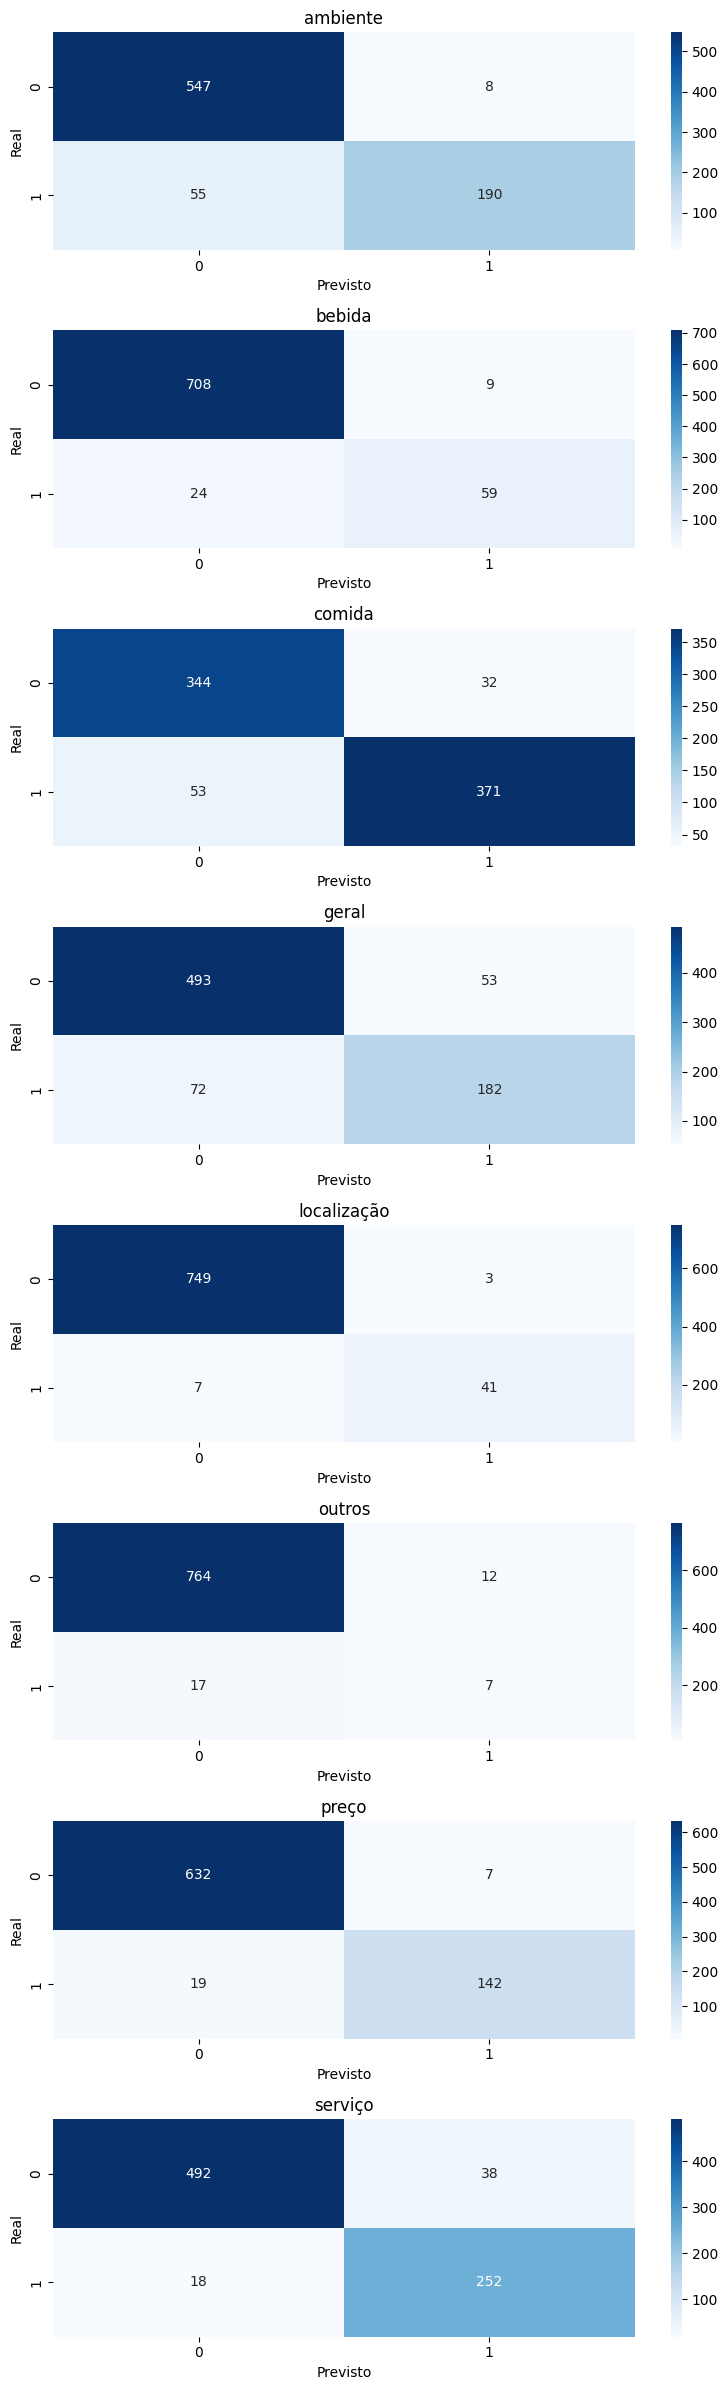

In [397]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 4° Fold

In [398]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold3, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold4)

In [399]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=1000)

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_015936/"
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20230428_015936/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11377.79 MB
	Train Data (Original)  Memory Usage: 0.64 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerato

Fitting TabularPredictor for label: ambiente ...


	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['text_ngram'])             : 156 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp_

Fitting TabularPredictor for label: bebida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   1 | ['ambiente']
		('int', ['text_ngram'])             : 156 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.3s = Fit runtime
	2 features in or

Fitting TabularPredictor for label: comida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 156 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.1s = Fit runti

Fitting TabularPredictor for label: geral ...


	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambi

Fitting TabularPredictor for label: localização ...


			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 's

Fitting TabularPredictor for label: outros ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('int', ['text_ngram'])             : 156 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__n

Fitting TabularPredictor for label: preço ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['text_ngram'])             : 156 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradá

Fitting TabularPredictor for label: serviço ...


		Fitting AsTypeFeatureGenerator...
			Note: Converting 7 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 155
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binn

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_015936/')


In [400]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [401]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 4° Fold:", accuracy)
print("F1 Score Macro do 4° Fold:", f1_score_macro)
print("Precisão Macro do 4° Fold:", precision_macro)
print("Revocação Macro do 4° Fold:", recall_macro)
print("F1 Score Micro do 4° Fold:", f1_score_micro)
print("Precisão Micro do 4° Fold:", precision_micro)
print("Revocação Micro do 4° Fold:", recall_micro)

Acurácia do 4° Fold: 0.63375
F1 Score Macro do 4° Fold: 0.7725428757612245
Precisão Macro do 4° Fold: 0.8254203965656012
Revocação Macro do 4° Fold: 0.7313467380004149
F1 Score Micro do 4° Fold: 0.8504043126684636
Precisão Micro do 4° Fold: 0.8800557880055788
Revocação Micro do 4° Fold: 0.8226857887874837


In [402]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9100
F1-Score: 0.8531
Precisão: 0.9248
Revocação: 0.7917
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9437
F1-Score: 0.7273
Precisão: 0.8333
Revocação: 0.6452
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8712
F1-Score: 0.8781
Precisão: 0.8961
Revocação: 0.8608
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8450
F1-Score: 0.7395
Precisão: 0.7652
Revocação: 0.7154
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9800
F1-Score: 0.8095
Precisão: 0.9444
Revocação: 0.7083
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9762
F1-Score: 0.2963
Precisão: 0.3636
Revocação: 0.2500
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9900
F1-Score: 0.9714
Precisão: 0.9927
Revocação: 0.9510
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

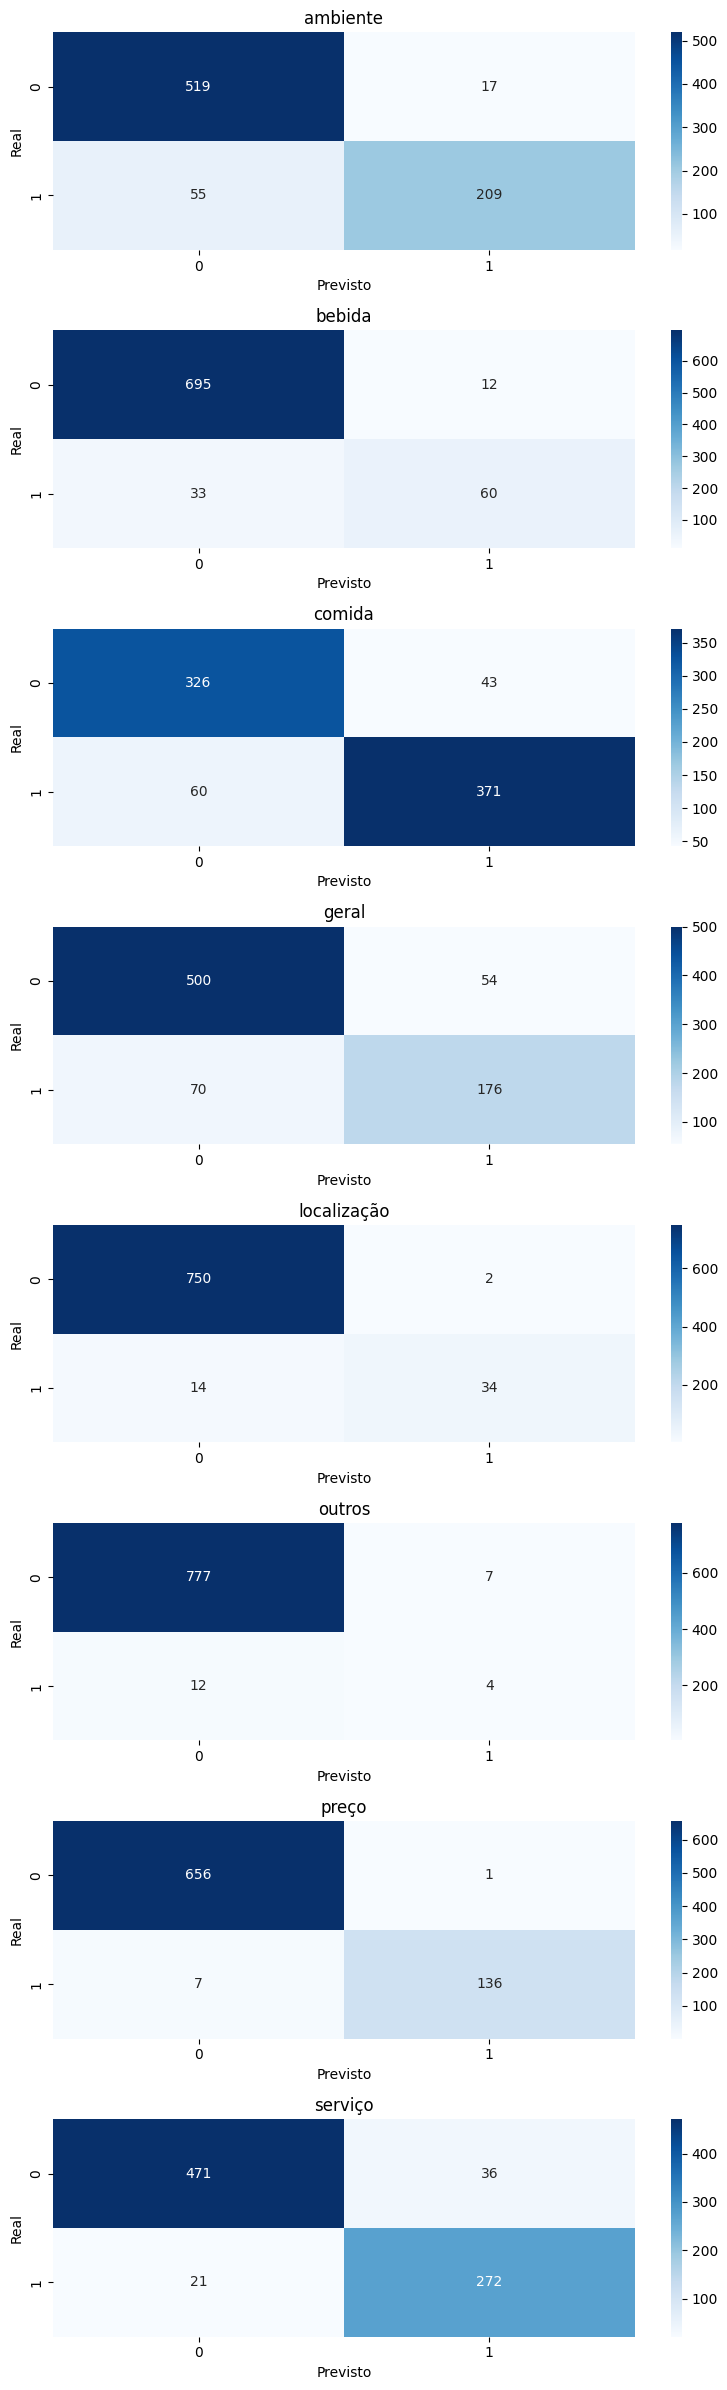

In [403]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 5° Fold

In [404]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold3, df_fold4])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold5)

In [405]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=1000)

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_020554/"
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20230428_020554/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11375.64 MB
	Train Data (Original)  Memory Usage: 0.64 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerato

Fitting TabularPredictor for label: ambiente ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['text_ngram'])             : 165 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.4s = Fit runtime
	1 features in original data used to generate 182 features in processed data.
	Train Data (Processed) Memory Usage: 1.

Fitting TabularPredictor for label: bebida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   1 | ['ambiente']
		('int', ['text_ngram'])             : 165 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.2s = Fit runtime
	2 features in or

Fitting TabularPredictor for label: comida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 165 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ...]
	1.2s = Fit runti

Fitting TabularPredictor for label: geral ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])             : 165 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradável', '__nlp__.agradável atendimento', '__nlp__.ainda', ..

Fitting TabularPredictor for label: localização ...


	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special

Fitting TabularPredictor for label: outros ...


			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.

Fitting TabularPredictor for label: preço ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :  16 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.lower_ratio', 'sentenca.digit_ratio', 'sentenca.special_ratio', ...]
		('int', ['bool'])                   :   6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['text_ngram'])             : 165 | ['__nlp__.acessível', '__nlp__.aconchegant', '__nlp__.agradá

Fitting TabularPredictor for label: serviço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 7 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 164
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_020554/')


In [406]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [407]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 5° Fold:", accuracy)
print("F1 Score Macro do 5° Fold:", f1_score_macro)
print("Precisão Macro do 5° Fold:", precision_macro)
print("Revocação Macro do 5° Fold:", recall_macro)
print("F1 Score Micro do 5° Fold:", f1_score_micro)
print("Precisão Micro do 5° Fold:", precision_micro)
print("Revocação Micro do 5° Fold:", recall_micro)

Acurácia do 5° Fold: 0.63875
F1 Score Macro do 5° Fold: 0.7605747369305891
Precisão Macro do 5° Fold: 0.8083784252718754
Revocação Macro do 5° Fold: 0.723995292649726
F1 Score Micro do 5° Fold: 0.850741123750431
Precisão Micro do 5° Fold: 0.8733191790516631
Revocação Micro do 5° Fold: 0.8293010752688172


In [408]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9250
F1-Score: 0.8678
Precisão: 0.9120
Revocação: 0.8277
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9613
F1-Score: 0.7559
Precisão: 0.9057
Revocação: 0.6486
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8712
F1-Score: 0.8745
Precisão: 0.8886
Revocação: 0.8609
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8512
F1-Score: 0.7473
Precisão: 0.7753
Revocação: 0.7213
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9788
F1-Score: 0.7671
Precisão: 0.9032
Revocação: 0.6667
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9637
F1-Score: 0.2162
Precisão: 0.2353
Revocação: 0.2000
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9825
F1-Score: 0.9573
Precisão: 0.9752
Revocação: 0.9401
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

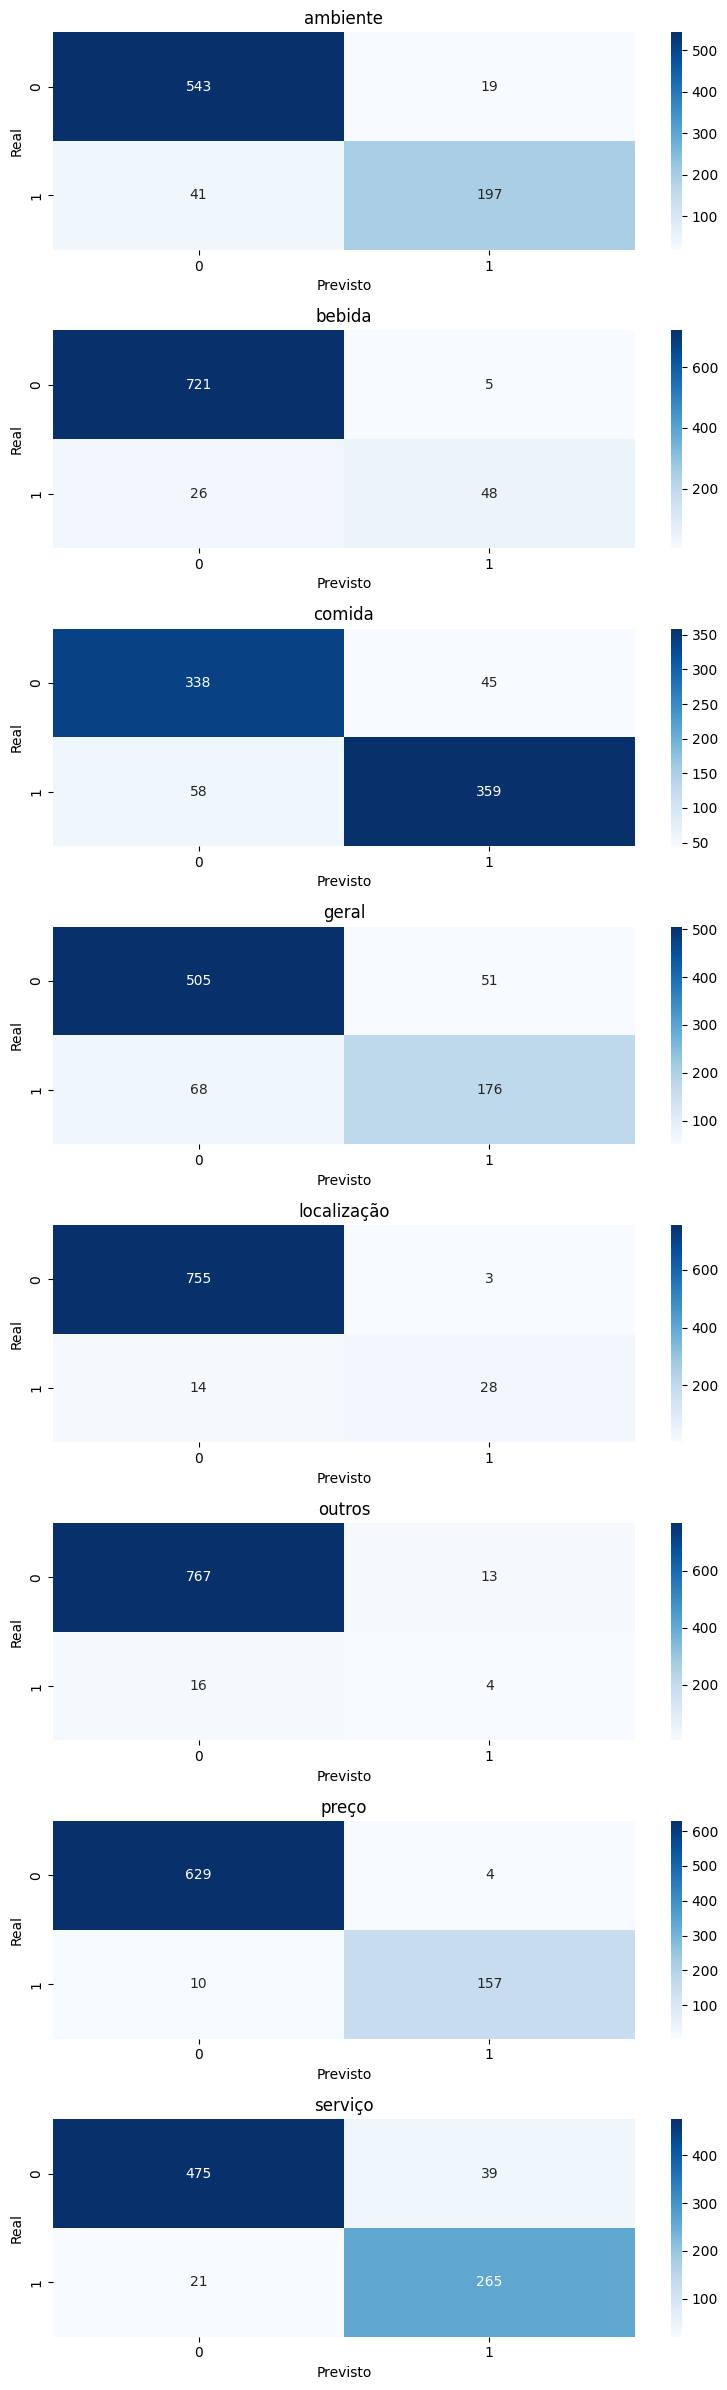

In [409]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## Resultado Geral do AutoGluon com Validação Cruzada

In [410]:
f1_score_list_macro

[0.7879237640580652,
 0.785753266089765,
 0.7892318351174097,
 0.7725428757612245,
 0.7605747369305891]

In [411]:
# Imprimir as métricas médias obtidas nas 5 partições
print("Acurácia média:", sum(accuracies) / len(accuracies))
print("F1 Score Macro médio:", sum(f1_score_list_macro) / len(f1_score_list_macro))
print("Precisão Macro média:", sum(precision_list_macro) / len(precision_list_macro))
print("Revocação Macro média:", sum(recall_list_macro) / len(recall_list_macro))
print("F1 Score Micro médio:", sum(f1_score_list_micro) / len(f1_score_list_micro))
print("Precisão Micro média:", sum(precision_list_micro) / len(precision_list_micro))
print("Revocação Micro média:", sum(recall_list_micro) / len(recall_list_micro))

Acurácia média: 0.63425
F1 Score Macro médio: 0.7792052955914107
Precisão Macro média: 0.8155506511059321
Revocação Macro média: 0.7514156437394737
F1 Score Micro médio: 0.8503671239132959
Precisão Micro média: 0.876692144838317
Revocação Micro média: 0.8256059227756415
